# Time Series with Fitbit Data

## Goals

## Summary

## Hypothesis:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# datetime manipulations
from datetime import datetime
import itertools as it

# modeling
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# supporting modules
import summarize
import acquire
import prepare

## Acquire

In [2]:
df = pd.read_csv('fitbit/tidy.csv')
# create an acquire function ***

*We decided to remove the food logs because they were mostly 0*

In [3]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


*Summary of the data we pulled in.*

In [4]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
          date calories_burned steps    distance      floors  \
count      225             225   225  225.000000  225.000000   
unique     225             207   213         NaN         NaN   
top     7/3/18           2,145     0         NaN         NaN   
freq         1               4    12         NaN         NaN   
mean    

## Prepare

In [5]:
# change date to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null datetime64[ns]
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 17.7+ KB


In [7]:
# set date as the index
df = df.sort_values('date').set_index('date')

In [8]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2018-04-27,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"


In [9]:
# remove any commas to change dtypes
df['calories_burned'] = df['calories_burned'].str.replace(',','')
df['steps'] = df['steps'].str.replace(',','')
df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
df['activity_calories'] = df['activity_calories'].str.replace(',','')

In [10]:
# change the data types to numeric dtypes
df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)

In [11]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
dtype: object

*Observation: There are 1440 minutes in a day.*

**Task: Create new column to track total minutes accounted for.**

In [12]:
# Add together all minutes of activity for total amount
df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']

*Observation: The average woman takes a stride of 2.2 and the average male takes a stride of 2.5.*

**Task: Create a new column to look at the average stride of a person to narrow in on details.**

In [13]:
# Divide distance by steps to find the average stride
df['distance_per_step'] = (df['distance'] / df['steps']) 

In [14]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471


**Takeaway:** Our fitbit wearer has an average stride of 2.4816, so chances are it is a male.

In [15]:
# dont know if miles or km
# mile = 2.5 step stride
# km = 1.5 step stride

# if we assume that steps are in miles, we can assume the participant is an American, therefore cn take American holidays into consideration
# taking calorie intake and stride into account, can find approximate weight for either male or female
# day of the week vs floor count - is there a spike difference?

In [16]:
df.steps.value_counts(ascending=False)

0        12
6480      2
5805      1
13511     1
9920      1
7806      1
10426     1
8377      1
2232      1
15542     1
12467     1
5807      1
14510     1
4313      1
207       1
15527     1
16705     1
1187      1
6815      1
7343      1
1689      1
7829      1
12360     1
9360      1
13798     1
8328      1
6344      1
2771      1
13958     1
5879      1
         ..
8996      1
3875      1
12544     1
9559      1
7512      1
5628      1
7029      1
4714      1
4486      1
13701     1
7043      1
2946      1
12157     1
16251     1
7034      1
5982      1
9591      1
2931      1
1639      1
3952      1
8559      1
7021      1
14696     1
8039      1
357       1
15714     1
17761     1
13664     1
4446      1
12569     1
Name: steps, Length: 213, dtype: int64

In [17]:
df_impute = df[df.steps == 0]

In [18]:
df_impute.groupby(df_impute.index.weekday_name).mean()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
Friday,2162.000000,0.0,0.0,0.0,1438.500000,1.500000,0.0,0.0,19.500000,1440.0,NaN
Monday,2146.000000,0.0,0.0,0.0,1440.000000,0.000000,0.0,0.0,0.000000,1440.0,NaN
Saturday,2145.000000,0.0,0.0,0.0,1440.000000,0.000000,0.0,0.0,0.000000,1440.0,NaN
Thursday,2148.000000,0.0,0.0,0.0,1439.666667,0.333333,0.0,0.0,3.333333,1440.0,NaN
Tuesday,2144.000000,0.0,0.0,0.0,1440.000000,0.000000,0.0,0.0,0.000000,1440.0,NaN
Wednesday,2157.666667,0.0,0.0,0.0,1439.333333,0.666667,0.0,0.0,14.000000,1440.0,NaN


In [19]:
df.sort_values(by='steps').head(15)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-06-27,2145,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-07-04,2183,0,0.00,0,1438,2,0,0,42,1440,NaN
2018-07-03,2144,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-06-30,2145,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-06-06,2145,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-06-07,2146,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-06-29,2180,0,0.00,0,1437,3,0,0,39,1440,NaN
2018-06-11,2146,0,0.00,0,1440,0,0,0,0,1440,NaN
2018-06-28,2145,0,0.00,0,1440,0,0,0,0,1440,NaN


In [20]:
def prepare_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
    df['calories_burned'] = df['calories_burned'].str.replace(',','')
    df['steps'] = df['steps'].str.replace(',','')
    df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
    df['activity_calories'] = df['activity_calories'].str.replace(',','')
    df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)
    df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']
    df['distance_per_step'] = (df['distance'] / df['steps'])
    return df 

In [21]:
# look at the steps average in days, weeks, and months

## Exploration

*Look at each feature to search to trends, anomalies, and correlations.*

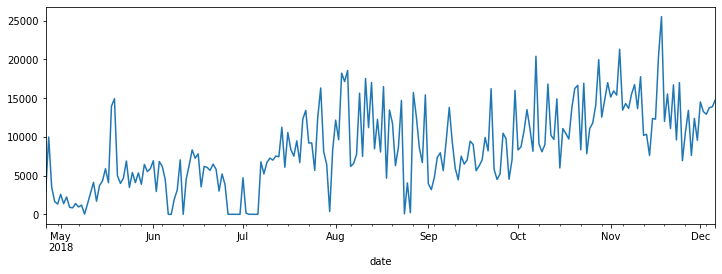

In [22]:
df['steps'].resample("D").mean().plot(figsize=(12,4))

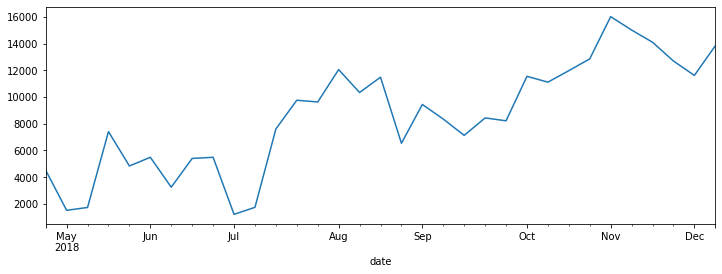

In [23]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

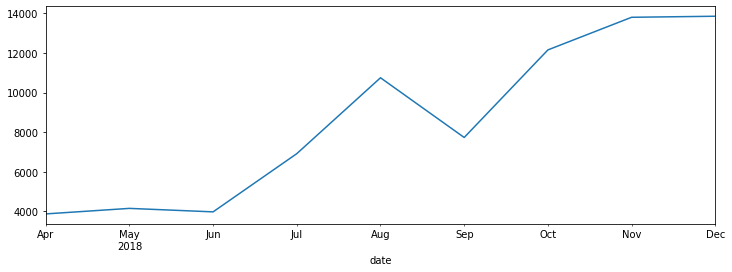

In [24]:
df['steps'].resample("M").mean().plot(figsize=(12,4))

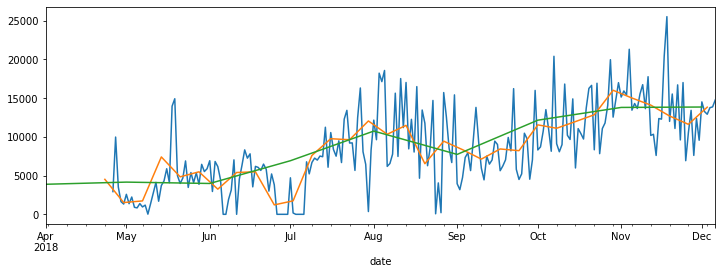

In [25]:
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

In [26]:
# look for days when there is a zero value
df.steps.sort_values().head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

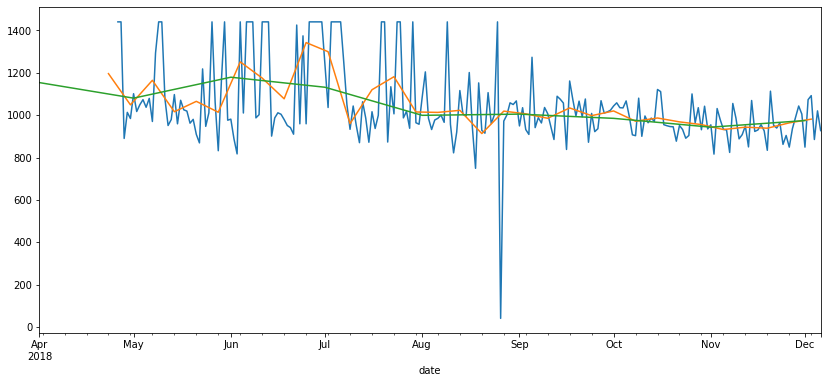

In [27]:
# started off strong in the beginning and then began to fall off the wagon a bit in the end
df['total_minutes_logged'].resample("D").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("W").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("M").mean().plot(figsize=(14,6))

In [28]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [29]:
# which month(s) has lowest amount of logged activity
df1 = df.resample("M").mean()
df1.sort_values(by='total_minutes_logged', ascending=True)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472


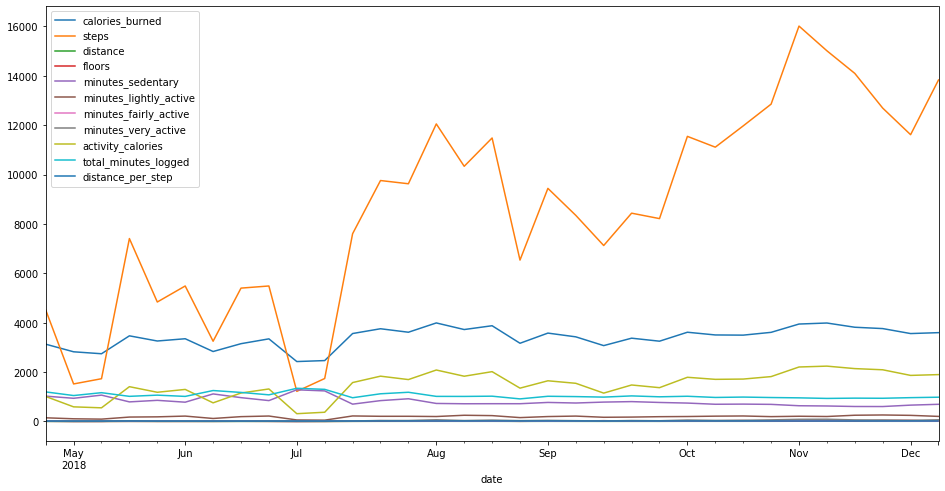

In [30]:
fig = df.resample("W").mean().plot(figsize=(16,8))

In [31]:
df.sort_index().steps.sort_values(ascending=True).head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

### Calories Burned

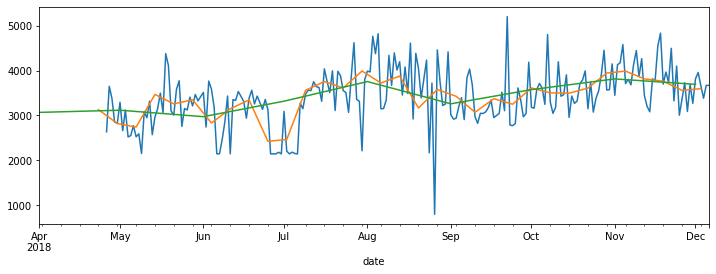

In [32]:
df['calories_burned'].resample("D").mean().plot(figsize=(12,4))
df['calories_burned'].resample("W").mean().plot(figsize=(12,4))
df['calories_burned'].resample("M").mean().plot(figsize=(12,4))

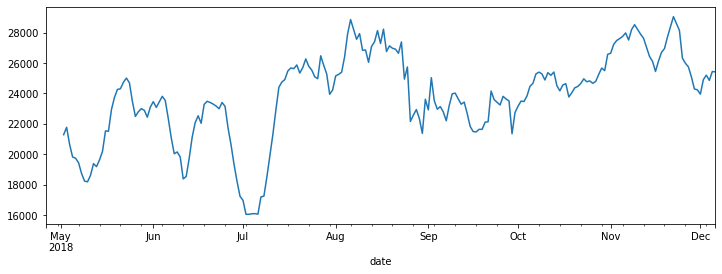

In [33]:
# every 7 days compared to resample("D")
df['calories_burned'].rolling(7).sum().plot(figsize=(12,4))

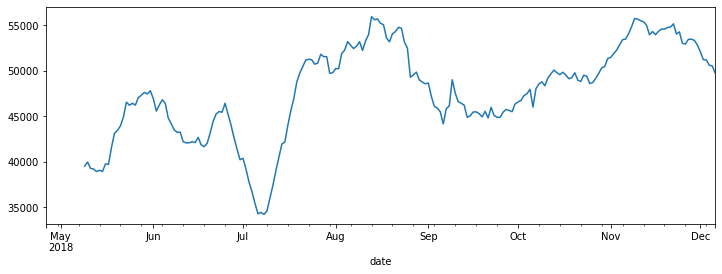

In [34]:
# every two weeks
df['calories_burned'].rolling(14).sum().plot(figsize=(12,4))

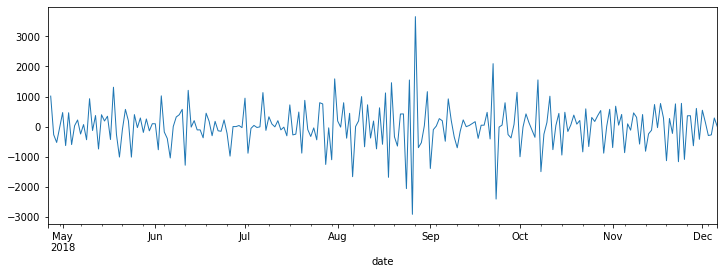

In [35]:
# difference between day to day
# something around the end of august
# task: look at month of august
df['calories_burned'].resample("D").mean().diff().plot(figsize=(12,4), linewidth=1)

*Add in a weekday and month column to look for seasonality in those time framses.*

In [36]:
df['weekday'] = df.index.weekday_name

In [37]:
df['month'] = df.index.month

In [38]:
df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4


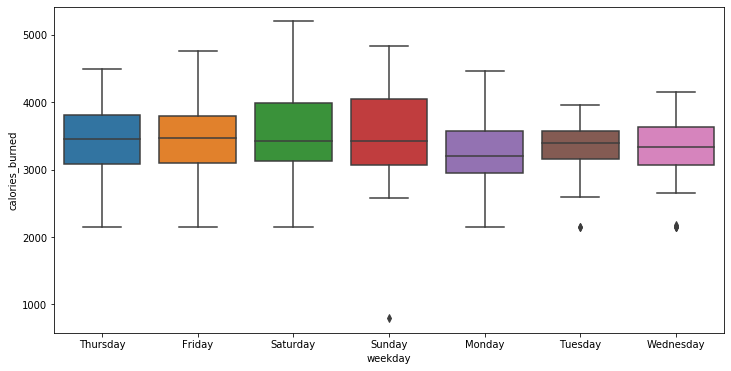

In [39]:
# burned more calories during the weekends
# a few outliers on Sundays/Tuesdays/Wednesdays
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='calories_burned')

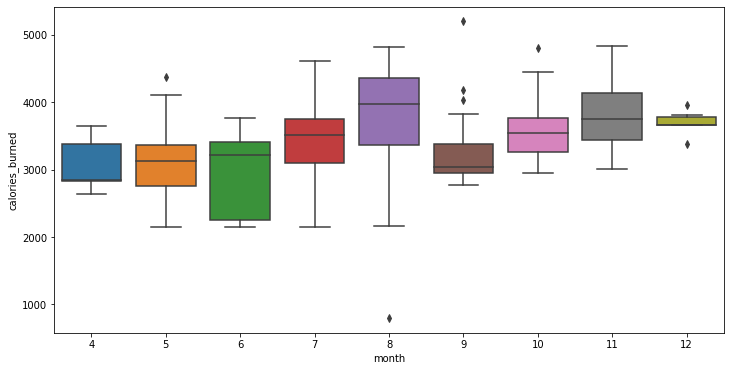

In [40]:
# more outliers each month for calories burned
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='calories_burned')

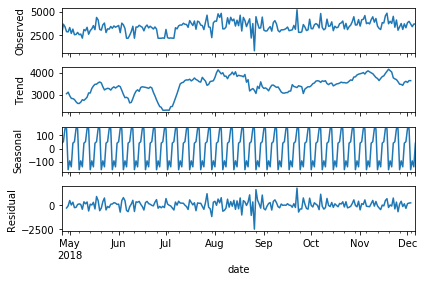

In [41]:
# no real trend in calories burned..
# no idea what seasonal is telling me
# residual looks very similar to observed 
# task: look at month
decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [42]:
# look at the trend for monthly

# decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("M").mean(), model='additive')
# fig = decomp.plot()
# plt.show()

### Steps

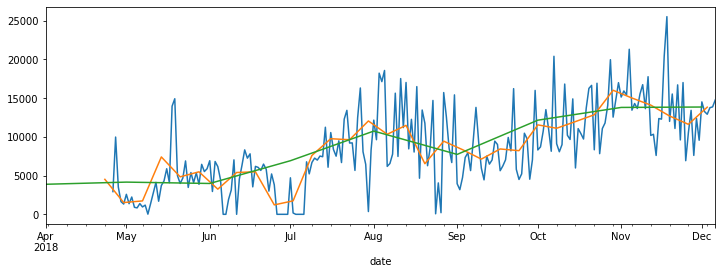

In [43]:
# steps
# uphill trend
# what do the peaks and valleys mean?
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

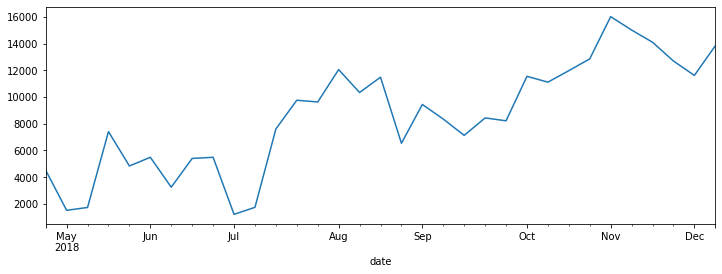

In [44]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

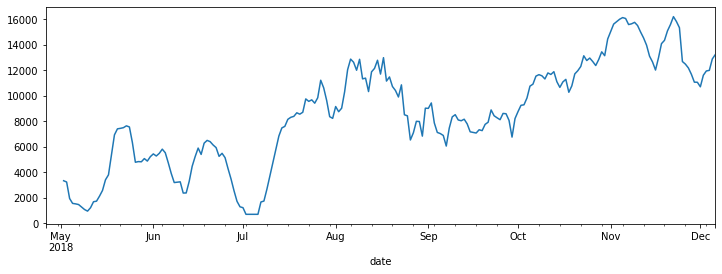

In [45]:
# how is this different from week? More rigidity in lines for this one
df['steps'].rolling(7).mean().plot(figsize=(12,4))

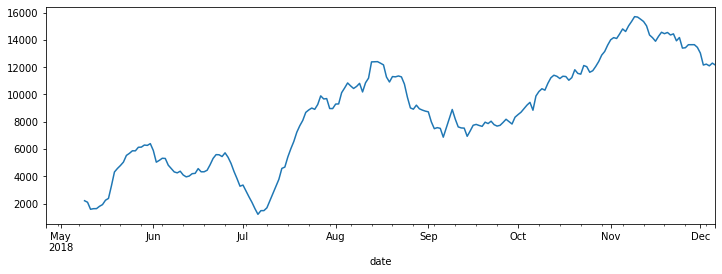

In [46]:
# every 2 weeks, see a clearer trend
df['steps'].rolling(14).mean().plot(figsize=(12,4))

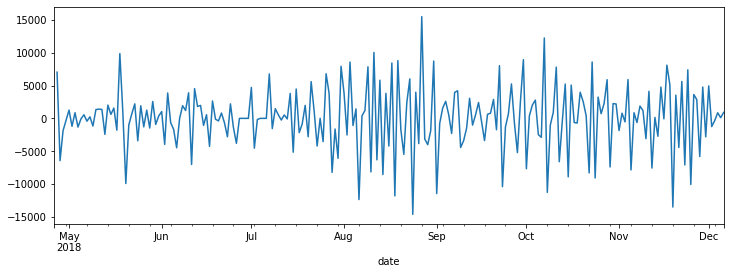

In [47]:
# there are differences from day to day that grow as the months go, there are more periods of negative the longer the wearer has the fitbit
df['steps'].resample("D").mean().diff().plot(figsize=(12,4))

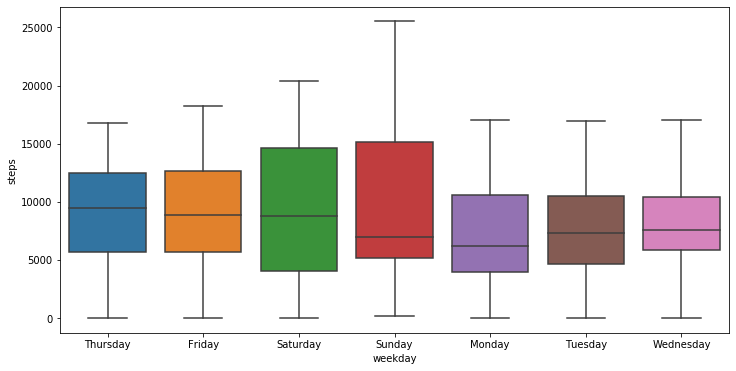

In [48]:
# again, can see that some days more active that others
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='steps')

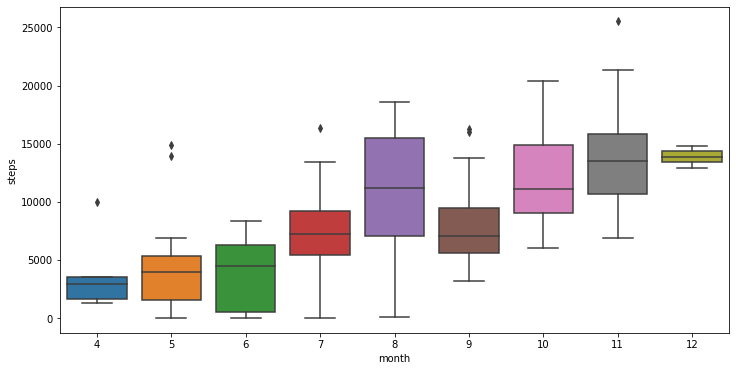

In [49]:
# outliers
# august 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='steps')

In [50]:
# august is 4th highest in steps --> look at box plot
# deal with outliers? figure out what they are 
df1.sort_values(by='steps', ascending=False)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470


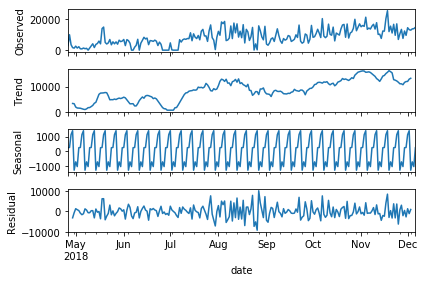

In [51]:
# uneven trend in steps, lots of noise (?), 
decomp = sm.tsa.seasonal_decompose(df['steps'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [52]:
# 5/9 only took 21 steps. maybe fill with mean value?
# 5/18-19 had sig more steps than average
df_mo = df.resample("D").mean()
d = df_mo.sort_values(by='month')
d[d.month == 5].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-05-09,2153,21,0.01,0,1438,2,0,0,8,1440,0.000476,5
2018-05-05,2551,833,0.39,0,969,68,0,0,326,1037,0.000468,5
2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476,5
2018-05-07,2524,952,0.45,0,907,63,0,0,283,970,0.000473,5
2018-05-08,2591,1187,0.56,2,1221,53,17,2,410,1293,0.000472,5
2018-05-10,3081,1364,0.64,0,1295,136,5,4,924,1440,0.000469,5
2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474,5
2018-05-06,2771,1383,0.65,0,976,103,0,0,506,1079,0.000470,5
2018-05-13,2572,1689,0.80,0,895,84,0,0,394,979,0.000474,5


In [53]:
# incomplete month, wide range of steps
# 4/27 higher than average
d[d.month == 4].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,4
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,4
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,4


In [54]:
# 7/3 - 7/6 no steps taken --> fill with mean value?
# 7/2 has sig less steps taken
# end of month has higher than average steps, days stagger
d[d.month == 7].sort_values(by='steps').tail(10)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-07-17,3760,8377,3.95,12,646,258,8,25,1803,937,0.000472,7
2018-07-23,3553,9203,4.34,5,748,204,23,31,1597,1006,0.000472,7
2018-07-24,3510,9215,4.35,6,1203,193,15,29,1551,1440,0.000472,7
2018-07-19,3993,9484,4.47,4,1116,243,57,24,2093,1440,0.000471,7
2018-07-16,4037,10551,4.98,4,714,204,51,47,2084,1016,0.000472,7
2018-07-14,3622,11239,5.30,10,709,203,39,35,1770,986,0.000472,7
2018-07-21,3983,12279,5.79,10,569,184,37,83,2162,873,0.000472,7
2018-07-26,3864,12467,5.88,10,704,214,11,58,1962,987,0.000472,7
2018-07-22,3883,13418,6.33,19,839,210,16,69,2015,1134,0.000472,7


In [55]:
# three days with lots of exercise
d[d.month == 9].sort_values(by='steps').tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-09-20,3517,9920,4.68,8,844,156,10,56,1565,1066,0.000472,9
2018-09-26,3613,10466,4.94,9,707,163,3,63,1677,936,0.000472,9
2018-09-08,4031,13798,6.65,16,634,237,16,76,2230,963,0.000482,9
2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,0.000472,9
2018-09-22,5199,16219,7.65,10,581,319,78,98,3596,1076,0.000472,9


In [56]:
# in general, november very active month for steps taken, range from 6921 - 25512
d[d.month == 11].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-11-25,3005,6921,3.26,11,614,281,3,6,1306,904,0.000471,11
2018-11-14,3081,7598,3.58,15,835,214,8,12,1250,1069,0.000471,11
2018-11-28,3088,7602,3.59,16,717,272,0,0,1361,989,0.000472,11
2018-11-30,3269,9559,4.51,14,699,288,12,6,1577,1005,0.000472,11
2018-11-23,3325,9602,4.53,16,660,269,23,12,1619,964,0.000472,11
2018-11-12,3444,10184,4.82,19,651,244,14,40,1705,949,0.000473,11
2018-11-13,3202,10330,4.87,16,615,199,10,26,1376,850,0.000471,11
2018-11-26,3364,10563,5.64,20,587,210,10,42,1605,849,0.000534,11
2018-11-21,3738,11079,5.16,4,582,328,9,33,2101,952,0.000466,11


### Distance

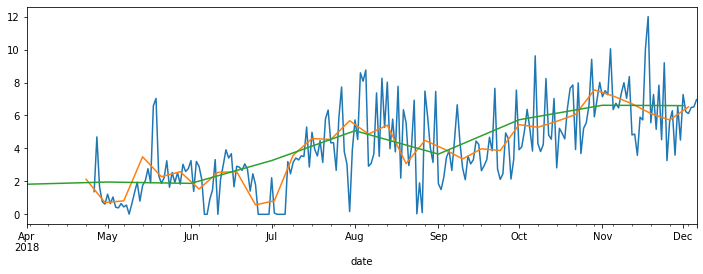

In [57]:
# distance 
df.distance.resample("D").mean().plot(figsize=(12,4))
df.distance.resample("W").mean().plot(figsize=(12,4))
df.distance.resample("M").mean().plot(figsize=(12,4))

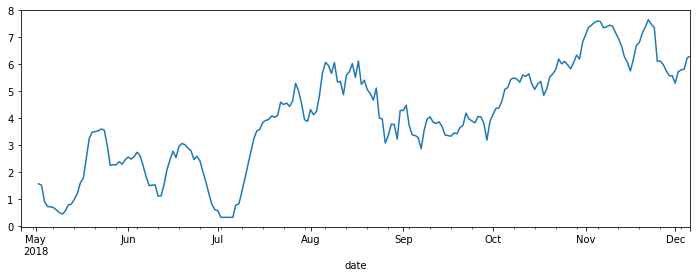

In [58]:
# one week/7 days
df.distance.rolling(7).mean().plot(figsize=(12,4))

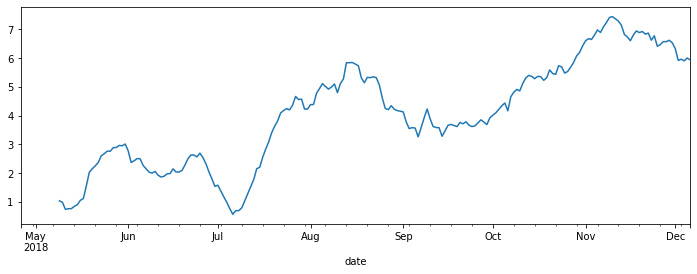

In [59]:
# every two weeks
df.distance.rolling(14).mean().plot(figsize=(12,4))

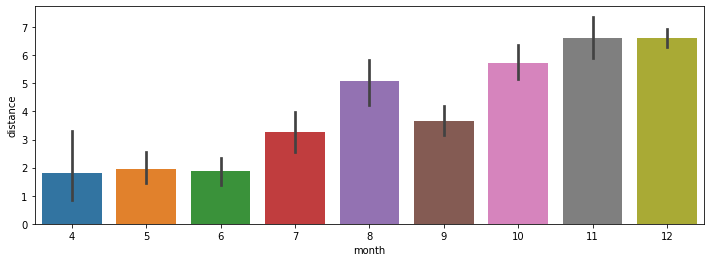

In [60]:
# follows trend of other vars, steps and calories burned, makes sense
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance')

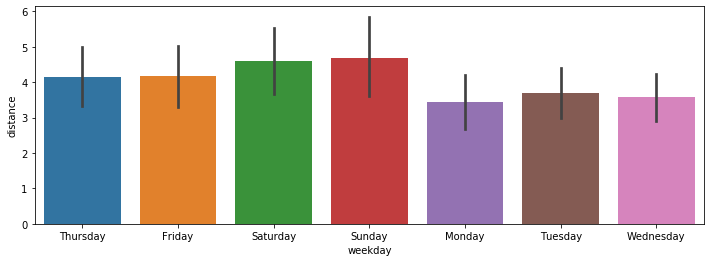

In [61]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance')

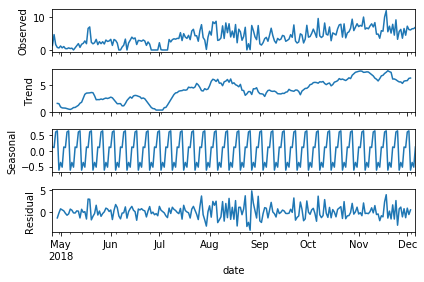

In [62]:
decomp = sm.tsa.seasonal_decompose(df['distance'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

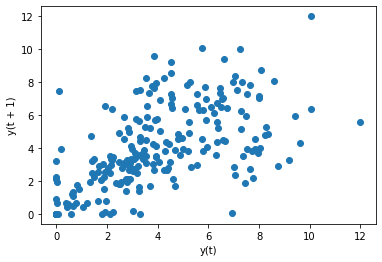

In [63]:
pd.plotting.lag_plot(df.distance.resample('D').mean(), lag=1)

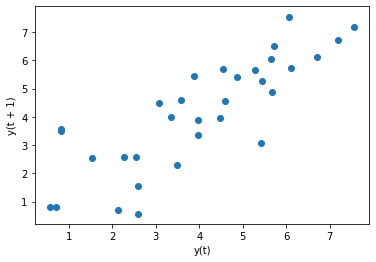

In [64]:
pd.plotting.lag_plot(df.distance.resample('W').mean(), lag=1)

### Distance per step

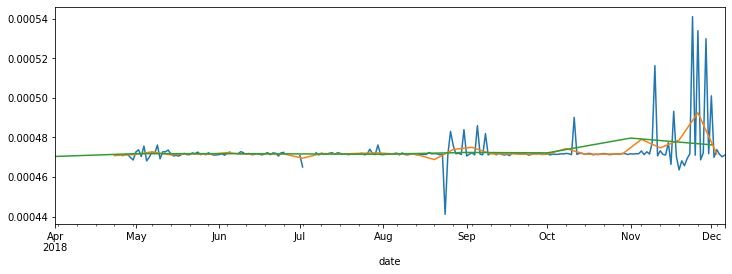

In [65]:
# distance per steps
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("M").mean().plot(figsize=(12,4))

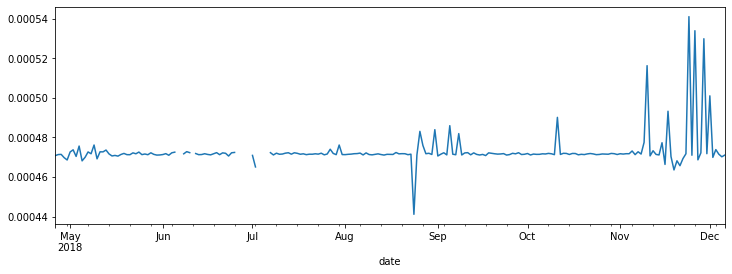

In [66]:
# gaps in the data around July, missing data for a few days
# large spike in distance per step around the end of the data
# dip around end of august, seen this before
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))

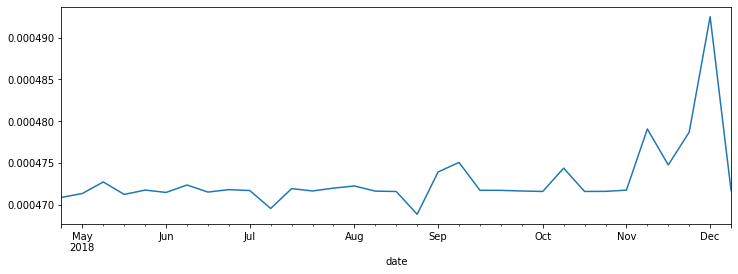

In [67]:
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))

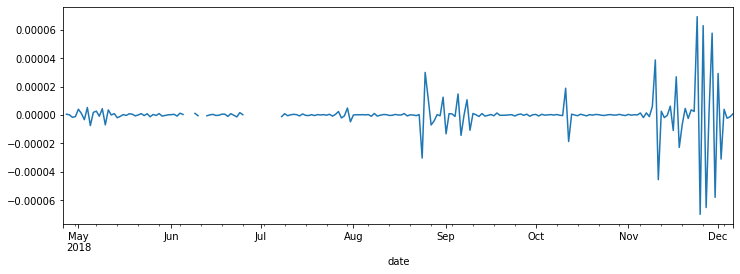

In [68]:
# steady in most parts, then large differences
df['distance_per_step'].resample("D").mean().diff().plot(figsize=(12,4))

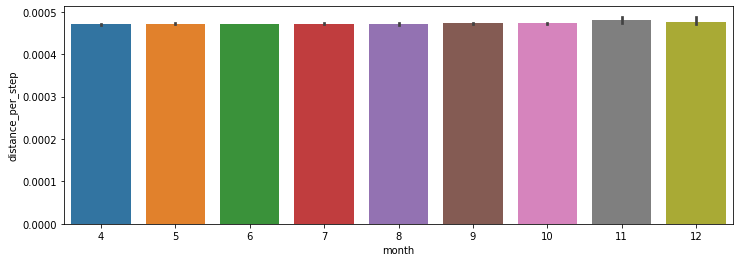

In [69]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance_per_step')

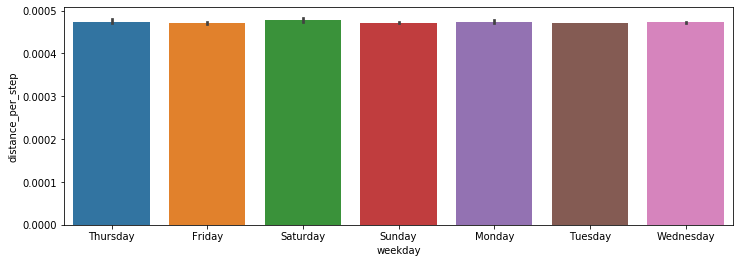

In [70]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance_per_step')

### Floors

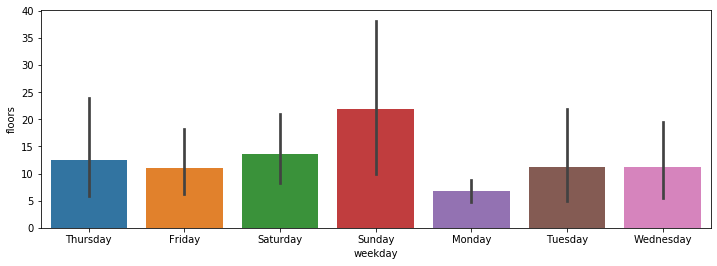

In [71]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='floors')

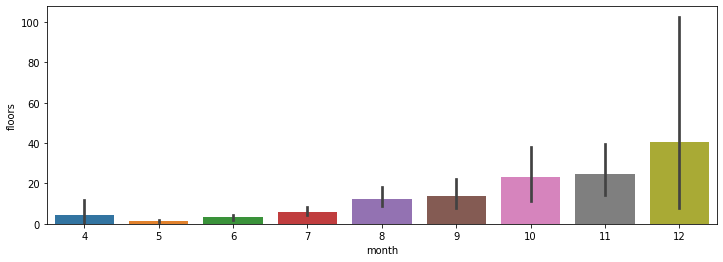

In [72]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='floors')

In [73]:
#Task: fill zeros ffill or bfill?
df.head()
# what do we want to predict? 
# predict steps

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,Thursday,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,Friday,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,Saturday,4
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,Sunday,4
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,Monday,4


In [74]:
df.activity_calories.value_counts()

0       9
1125    2
1684    2
1427    2
1630    2
1068    2
1172    2
1330    2
1127    2
1962    2
1530    2
2224    1
1714    1
1196    1
1195    1
1705    1
1185    1
1175    1
2717    1
1689    1
2228    1
2436    1
2958    1
1678    1
1677    1
1669    1
2692    1
1663    1
2686    1
1715    1
       ..
1287    1
2305    1
1278    1
1787    1
822     1
2361    1
1852    1
829     1
2418    1
1389    1
1388    1
1895    1
1382    1
1376    1
1375    1
2398    1
2907    1
1882    1
3344    1
853     1
852     1
1874    1
1361    1
1872    1
1354    1
1074    1
326     1
1298    1
1343    1
1266    1
Name: activity_calories, Length: 207, dtype: int64

### Total minutes logged

In [75]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [76]:
weekday_totals = df.groupby(df.index.weekday).sum()

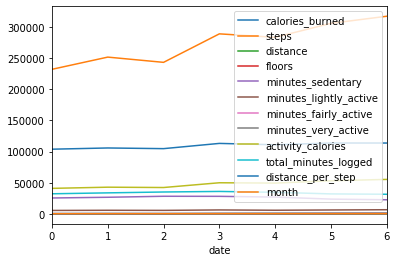

In [77]:
weekday_totals.plot()

In [78]:
df = df.resample('D').mean()

### Minutes Sedentary

Text(0.5, 1.0, 'Average Sedentary Minutes by Day')

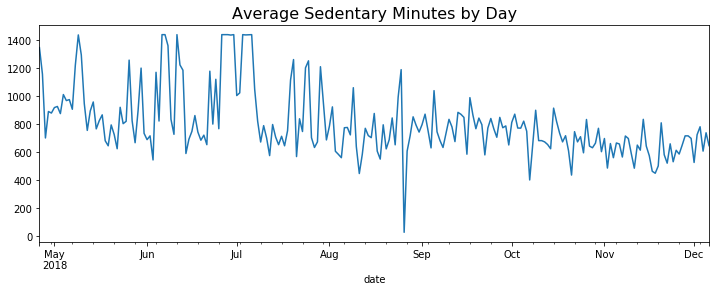

In [79]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Day')

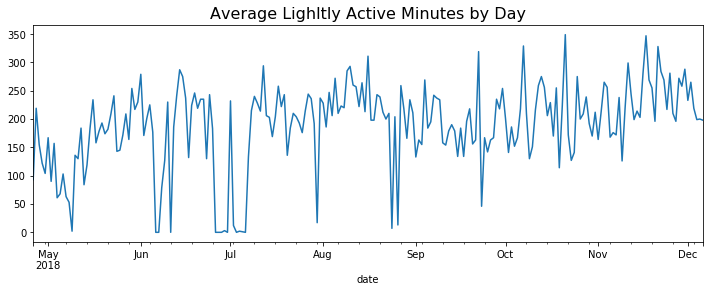

In [80]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day')

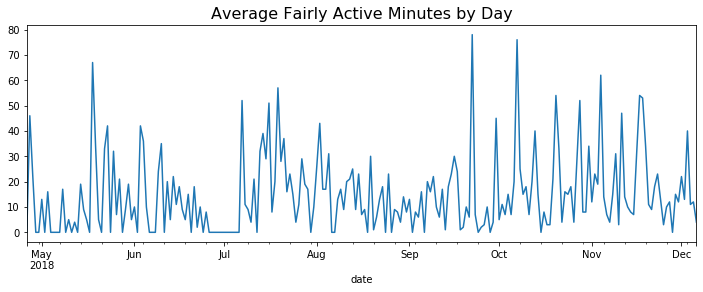

In [81]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Day')

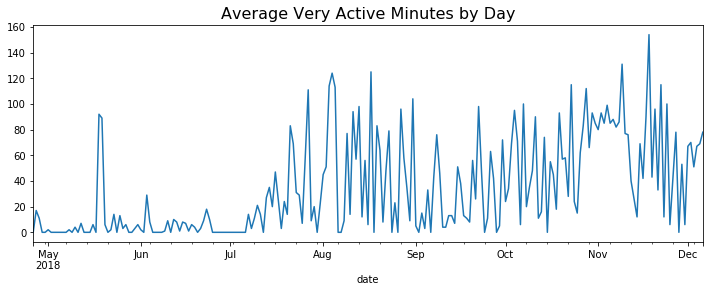

In [82]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Day', fontsize=16)

**Takeaway:** Thanksgiving was on Thurs Nov 22nd and it was user's 7th most active day and 5th most very active day

Text(0.5, 1.0, 'Average Minutes per Activity Level by Day')

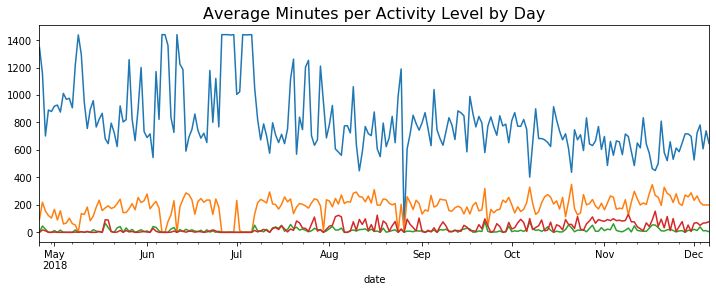

In [83]:
df = df.resample('D').mean()

fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Day', fontsize=16)

**Takeaways:**
    - August 26th, user only wore fitbit for 41 mins
    - Wore fitbit all day a few times in July but never again after that

In [84]:
df = df.resample('W').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Week')

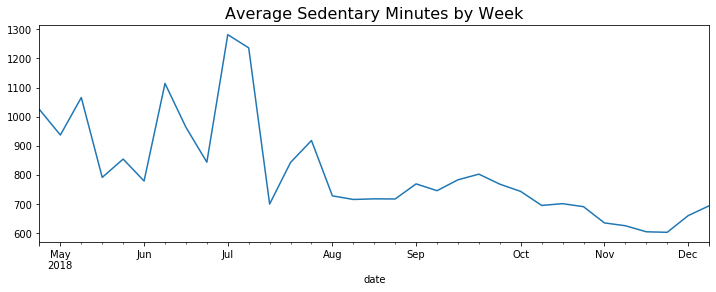

In [85]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Week')

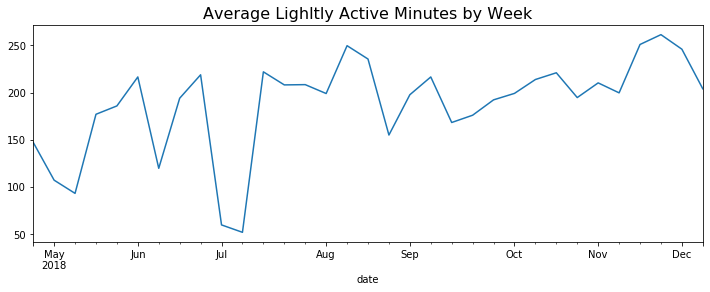

In [86]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Week')

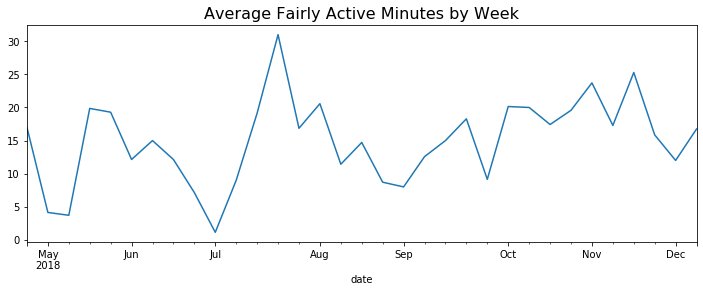

In [87]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Week')

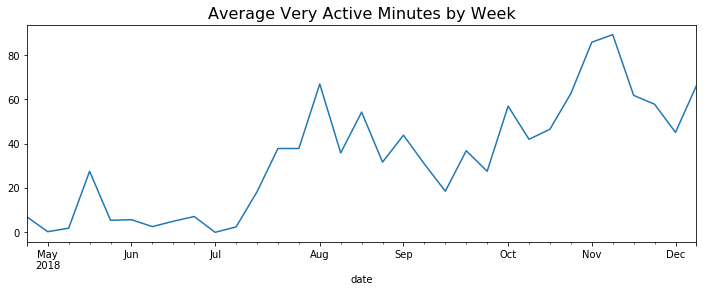

In [88]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Week')

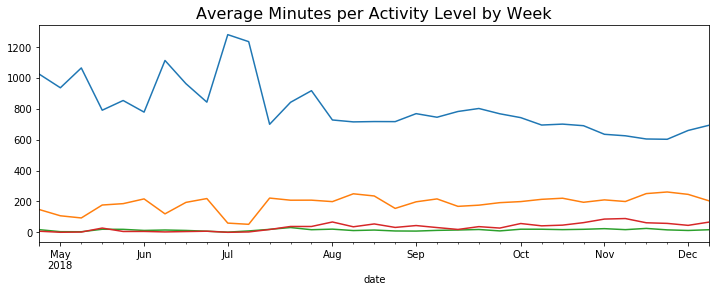

In [89]:
df = df.resample('W').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Week', fontsize=16)

**Takeaway:** April - July active levels have high variance including a very inactive first week of July. August through Dec is more constant. 

In [90]:
df = df.resample('M').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Month')

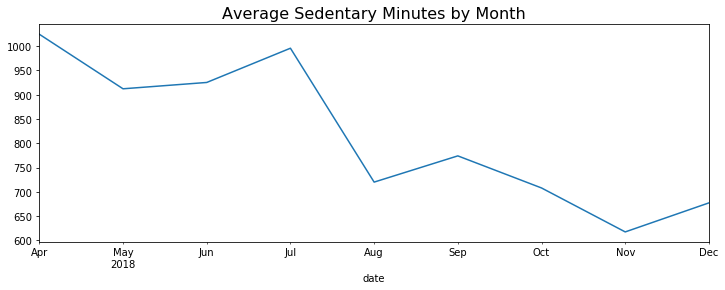

In [91]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Month')

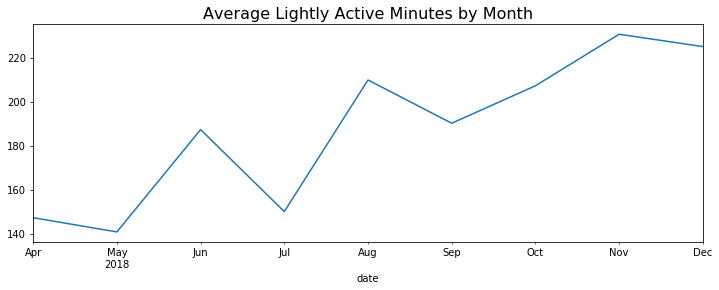

In [92]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lightly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Month')

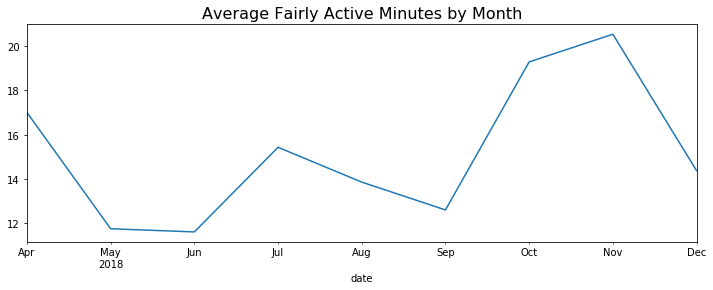

In [93]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Month')

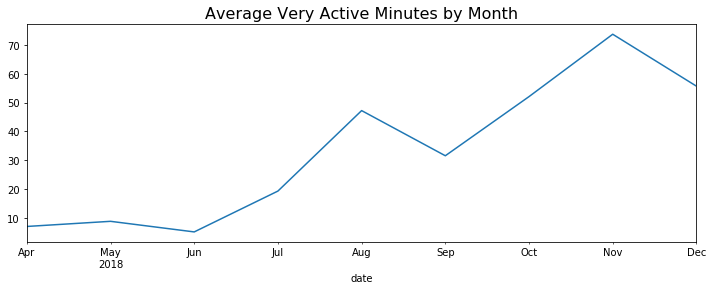

In [94]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Month')

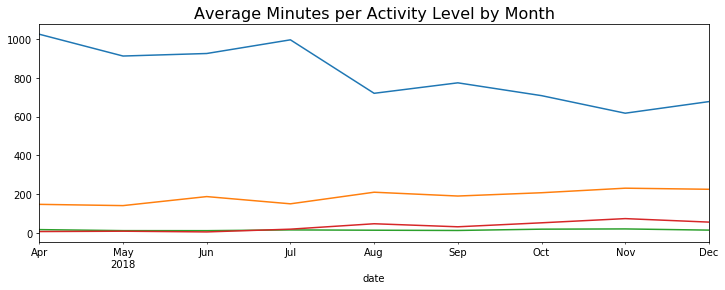

In [95]:
df = df.resample('M').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Month', fontsize=16)

**Takeaway:** Sedentary levels go down over time. Fitbit user becomes more consistently active as time goes on. 

Text(0.5, 1.0, 'Average Very Active Minutes by Day of Week')

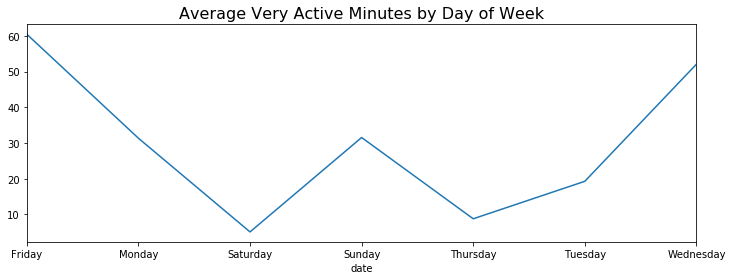

In [96]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_1 = daily_averages['minutes_very_active'].plot(figsize= (12,4))
fig_1.set_title('Average Very Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day of Week')

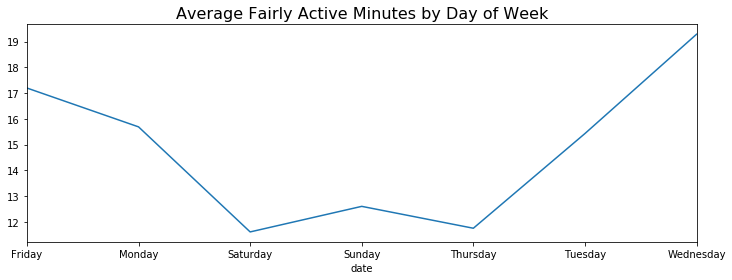

In [97]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_2 = daily_averages['minutes_fairly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Fairly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Day of Week')

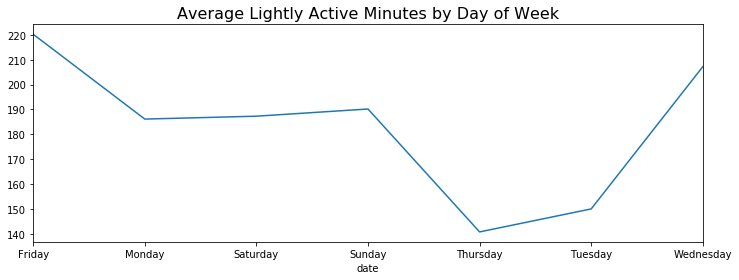

In [98]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_3 = daily_averages['minutes_lightly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Lightly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Sedentary Minutes by Day of Week')

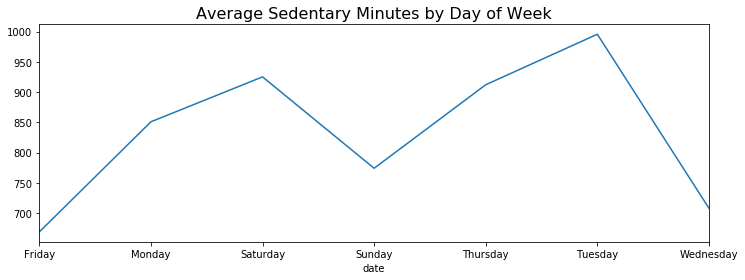

In [99]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_4 = daily_averages['minutes_sedentary'].plot(figsize= (12,4))
fig_4.set_title('Average Sedentary Minutes by Day of Week', fontsize=16)

**Takeaway:** Fitbit user is most active on Fridays and Wednesday. They do next to nothing on Tuesday and are also very inactive on Saturdays

## Modeling

In [100]:
# fix prepare index part
df.shape

(246, 12)

In [101]:
df = acquire.acquire_data()

In [102]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [103]:
df = prepare.prepare_data(df)

In [104]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469


In [105]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [106]:
train, test = split_store_data(df, train_prop=.70)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 157
Testing Observations: 68


In [107]:
train.tail(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-09-29,3043,7043,3.32,5,788,218,4,5,1220,1015,0.000471


In [108]:
test.head(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,0.000472


In [109]:
target_vars=['steps']
df = df.resample('D')[target_vars].sum()

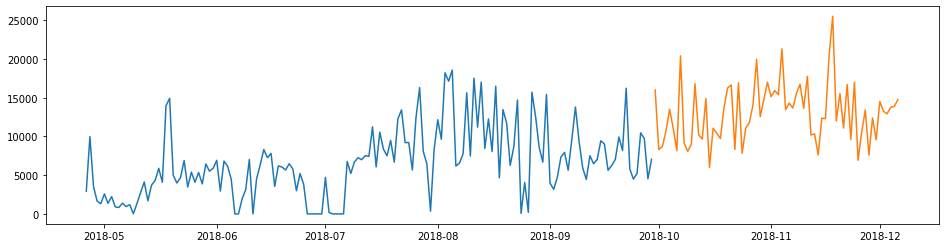

In [110]:
# look at the split to compare
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [111]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [112]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [113]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [114]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

Last Observed Value

In [115]:
yhat = pd.DataFrame(test[target_vars])

In [116]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [117]:
# last value in the train df becomes prediction
yhat.head()

,steps
date,
2018-09-30,7043
2018-10-01,7043
2018-10-02,7043
2018-10-03,7043
2018-10-04,7043


In [118]:
# checking that each predicted value is the same
for var in target_vars:
    print(var, ":", yhat[var].min() == yhat[var].max())

steps : True


steps -- MSE: 51102765.85 RMSE: 7148.62


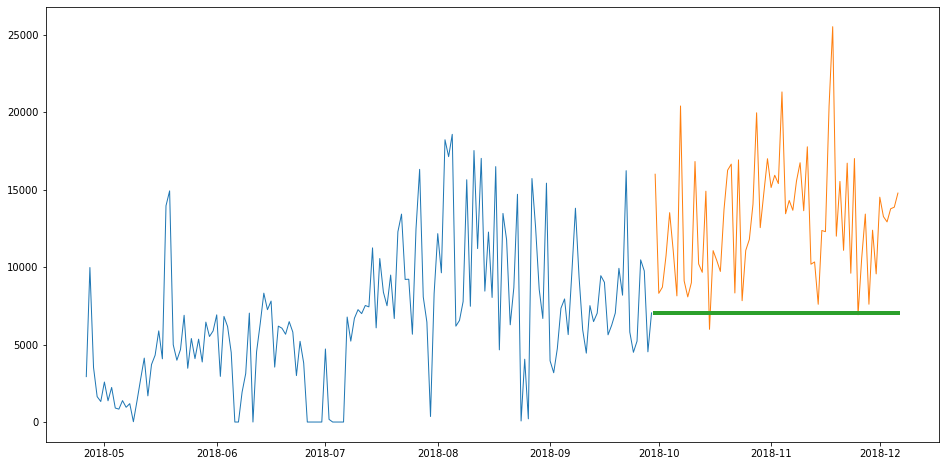

In [119]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

In [120]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=target_vars, train = train, test = test)

In [121]:
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,5.110277e+07
1,last_observed_value,steps,rmse,7.148620e+03


Simple Average

In [122]:
# takes average
for var in target_vars:
    yhat[var] = train[var].mean()

steps -- MSE: 57072047.89 RMSE: 7554.60


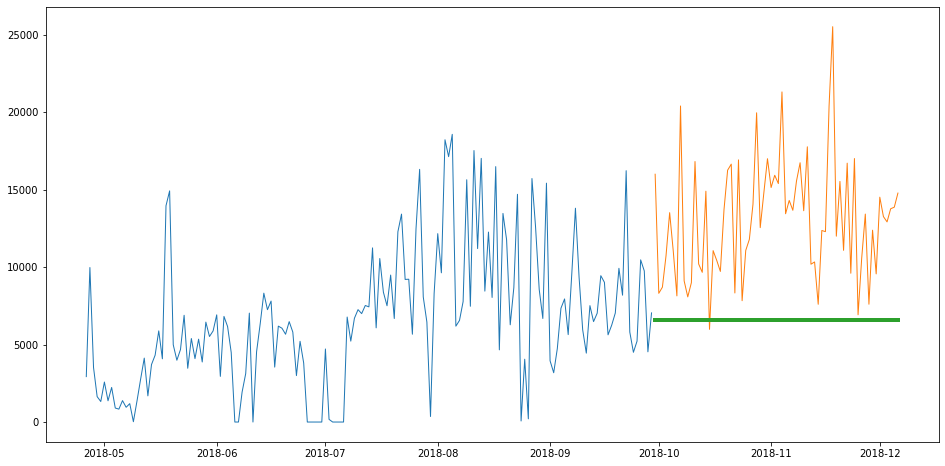

In [123]:
plot_and_eval(target_vars, train = train, test = test)

In [124]:
eval_df = append_eval_df(model_type='simple_average', target_vars=target_vars, train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,5.110277e+07
1,last_observed_value,steps,rmse,7.148620e+03
2,simple_average,steps,mse,5.707205e+07
3,simple_average,steps,rmse,7.554604e+03


Moving Average

In [125]:
periods = 14
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

steps -- MSE: 42258628.82 RMSE: 6500.66


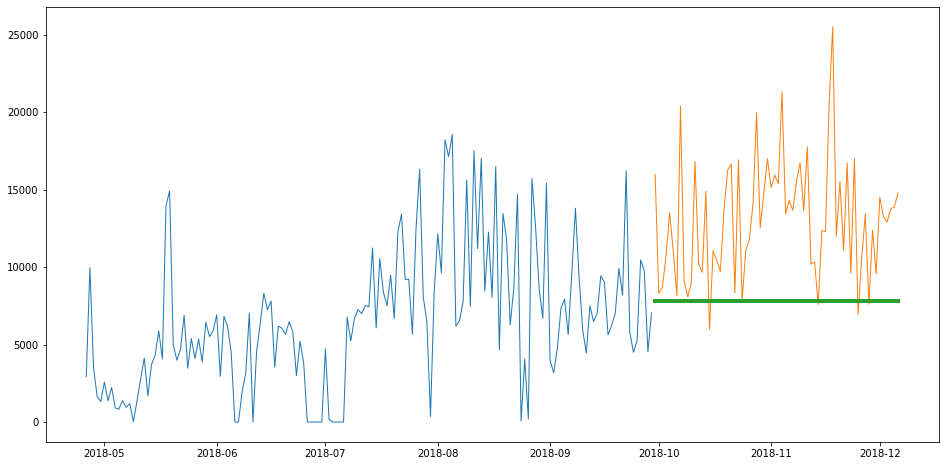

In [126]:
plot_and_eval(target_vars, train = train, test = test)

In [127]:
eval_df = append_eval_df(model_type='moving_average', target_vars=target_vars, train = train, test = test)

In [128]:
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,5.110277e+07
1,last_observed_value,steps,rmse,7.148620e+03
2,simple_average,steps,mse,5.707205e+07
3,simple_average,steps,rmse,7.554604e+03
4,moving_average,steps,mse,4.225863e+07
5,moving_average,steps,rmse,6.500664e+03


steps -- MSE: 43460991.94 RMSE: 6592.50


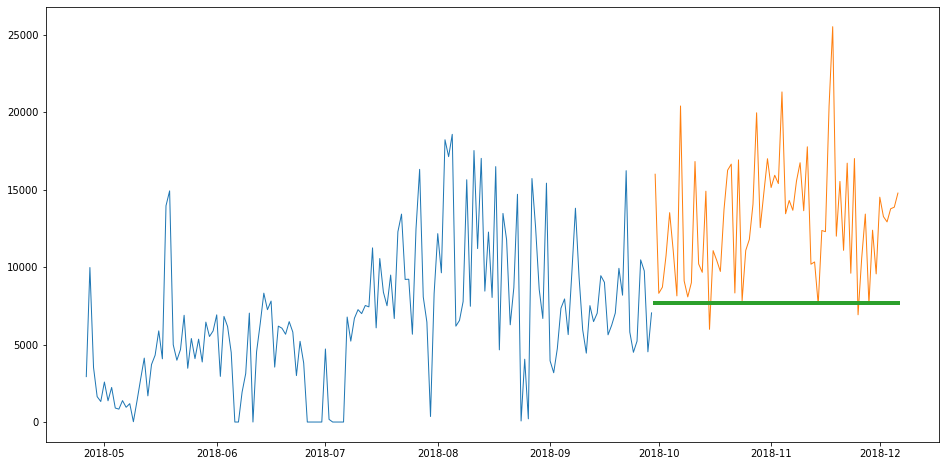


rolling averge period: 1
steps
MSE:  51102765.85294118
RMSE: 7148.619856513646

rolling averge period: 2
steps
MSE:  67849309.38235295
RMSE: 8237.069222870046

rolling averge period: 3
steps
MSE:  50317988.25816995
RMSE: 7093.517340372824

rolling averge period: 4
steps
MSE:  40994459.78308824
RMSE: 6402.691604558839

rolling averge period: 5
steps
MSE:  46895919.38235294
RMSE: 6848.059534083574

rolling averge period: 6
steps
MSE:  52623936.29738563
RMSE: 7254.235748677157

rolling averge period: 7
steps
MSE:  54606131.15426171
RMSE: 7389.5961428390465

rolling averge period: 8
steps
MSE:  41053532.323529415
RMSE: 6407.303046019395

rolling averge period: 9
steps
MSE:  40776721.97058824
RMSE: 6385.665350657537

rolling averge period: 10
steps
MSE:  38819842.574705884
RMSE: 6230.557164066941

rolling averge period: 11
steps
MSE:  39840813.09747205
RMSE: 6311.957944843426

rolling averge period: 12
steps
MSE:  41381768.00816993
RMSE: 6432.866235836863

rolling averge period: 13
steps
M

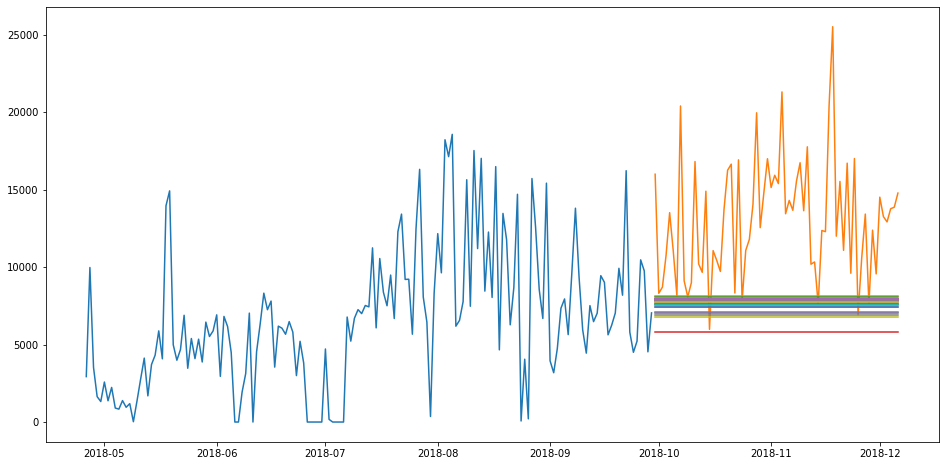

In [129]:
periods = 30
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='moving_average', target_vars=target_vars, train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = range(1,30)
for p in period_vals:
    for var in target_vars:
        yhat[var] = train[var].rolling(p).mean().iloc[-1]
        plt.plot(yhat[var])
        print('\nrolling averge period:',p)
        print(var)
        evaluate(var, train = train, test = test)

Holt's Linear Trend

steps 



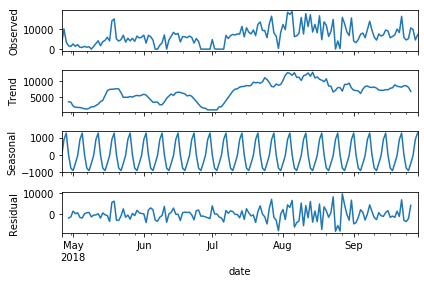

In [130]:
for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('D').mean()).plot()
    plt.show()

Fit Basic Holt's Linear Trend Model

steps -- MSE: 85852024.23 RMSE: 9265.64


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


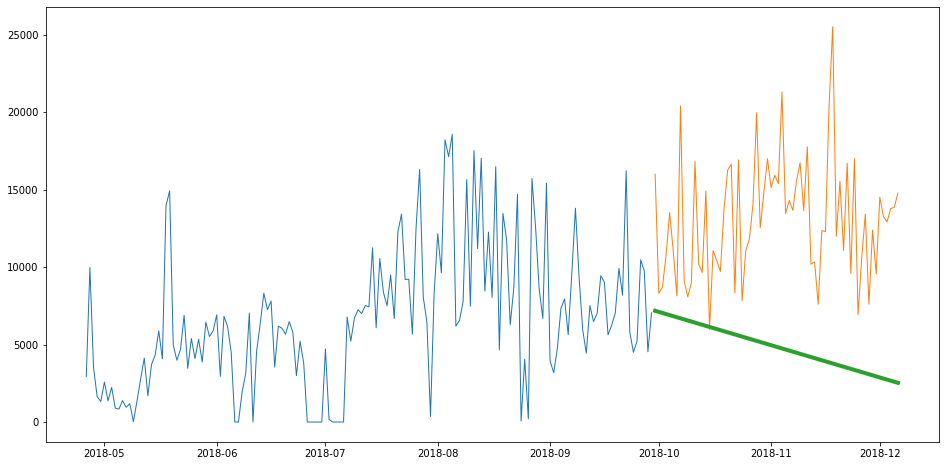

In [131]:
for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

Fit Holt's Exponential Linear Trend

In [132]:
# for var in target_vars:
#     model = Holt(train[var], exponential=True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
#     yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='holts_exponential_trend', target_vars=target_vars, train = train, test = test)

Predicting Based on the Previous Cycle

In [133]:
# yhat = train['2018-09-01':'2018-09-29'].mean()
# # set the date (index) to be represent the date for our predictions
# yhat.index = pd.date_range('20', periods=len(yhat))
# yhat.tail()

In [134]:
# train1 = train['2018-09-01':'2018-09-29']
# test1 = test['2016-04-20':'2017-04-20']

# plot_and_eval(target_vars, train = train1, test = test1, linewidth=1)
# eval_df = append_eval_df(model_type='previous_year', target_vars=target_vars, train = train1, test = test1)

Text(0.5, 1.0, 'Test')

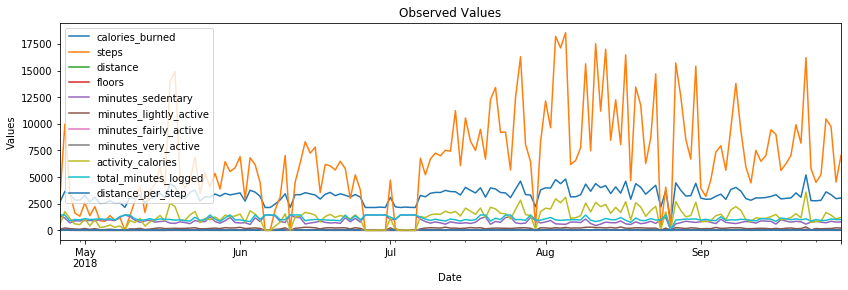

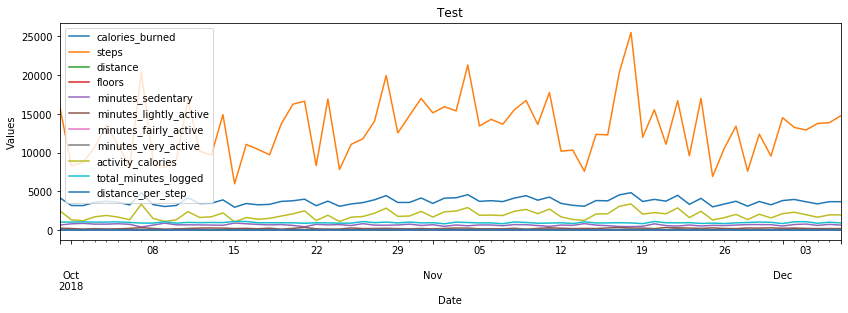

In [135]:
train.plot(figsize=(14,4))
plt.xlabel('Date')
plt.ylabel("Values")
plt.title("Observed Values")
test.plot(figsize=(14,4))
plt.xlabel('Date')
plt.ylabel("Values")
plt.title("Test")

In [136]:
## to do:
# organize notebook
# data dictionary
# combine exploration
# label graphs
# read me 
# slides
# impute missing days 

## slide 1 - graph with to see overall trends, points in the data we looked into, 